<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/hssm.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(ddm-notebook)=
# Drift Diffusion Model

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az  # Visualization
import hssm
from ssms.basic_simulators import simulator
import pymc as pm
import pymc.sampling_jax

/Users/corrado/mambaforge/envs/hssm_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [42]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 6783
rng = np.random.default_rng(RANDOM_SEED)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
sns.set_palette("colorblind")

## Predizione contro spiegazione

Nella ricerca scientifica, due orientamenti metodologici ed epistemologici fondamentali caratterizzano l'analisi dei dati. Il primo mira primariamente alla spiegazione dei fenomeni osservati. Utilizzando metodi quantitativi, questo approccio aspira a identificare relazioni causali, risultando nella creazione di modelli che si adattano in modo ottimale ai dati specifici da cui sono stati generati. Tuttavia, questa focalizzazione sulla spiegazione può limitare la replicabilità e la generalizzabilità delle scoperte.

In contrasto, il secondo orientamento è incentrato sulla predizione. In questo quadro, si utilizzano tecniche di apprendimento automatico, o "machine learning", per minimizzare l'errore su un insieme di dati ancora non esaminati, noto come set 'held-out'. Qui, l'attenzione è rivolta alla performance predittiva, a discapito dell'interpretabilità e della coerenza teorica. Questo approccio non è privo di limitazioni, tra le quali figurano la complessità e la mancanza di interpretabilità dei modelli generati.

Recenti contributi, come l'articolo del 2021 di Hofman e colleghi, hanno enfatizzato la necessità di un approccio più equilibrato che integri sia la spiegazione che la predizione. Una risposta a questa esigenza emerge dalla psichiatria computazionale, un campo in rapido sviluppo che è di particolare interesse per la psicologia e le neuroscienze. Questo approccio ambisce a costruire modelli capaci sia di spiegare che di prevedere i fenomeni osservati, offrendo una comprensione più profonda attraverso simulazioni e analisi dettagliate.

Dal punto di vista epistemologico, la psichiatria computazionale rappresenta un netto distacco dall'approccio Null Hypothesis Significance Testing (NHST), che ha dominato la psicologia per lungo tempo. L'NHST ha suscitato numerose critiche per il suo utilizzo inappropriato, che include esperimenti sottodimensionati e problemi con la replicabilità. Inoltre, l'NHST è intrinsecamente problematico quando si tratta di integrare spiegazione e predizione. Sebbene utilizzi il linguaggio della predizione, le sue implicazioni sono spesso limitate alla mera affermazione che l'effetto osservato non è nullo, fornendo quindi un test debolissimo delle teorie scientifiche.

Anche i metodi puramente predittivi possono confondere la predizione con la spiegazione. Sebbene questi modelli possano mostrare un'accuratezza impressionante, essi sono spesso condizionati dall'assunzione di stabilità nelle relazioni tra variabili. Questo limita la loro applicabilità e può portare a interpretazioni fuorvianti.

Contrastando queste limitazioni, la psichiatria computazionale si propone di scoprire i meccanismi causali alla base dei fenomeni psicologici. A differenza dell'NHST, questo approccio permette di generare spiegazioni falsificabili e di effettuare predizioni quantitative rigorose. Alcuni modelli rappresentativi di questo paradigma includono il modello di Rescorla-Wagner per l'apprendimento per rinforzo e il Drift Diffusion Model. L'approccio bayesiano può essere impiegato per affinare ulteriormente la stima dei parametri di questi modelli, armonizzando così le esigenze di spiegazione e predizione in un quadro teorico coeso.

Nel seguente capitolo, esamineremo più da vicino il Drift Diffusion Model, uno dei modelli chiave della psichiatria computazionale, e discuteremo come l'approccio bayesiano possa contribuire alla sua parametrizzazione e interpretazione.

## Il modello dei tempi di reazione

Il Drift Diffusion Model (DDM) è un modello computazionale ampiamente utilizzato per analizzare i dati sui tempi di reazione e le scelte in compiti di decisione binaria. Originariamente derivato dalla teoria delle decisioni sequenziali, il DDM fornisce un quadro per comprendere come le decisioni vengano prese in situazioni di incertezza e sotto vincoli temporali. Il modello è particolarmente utile per esaminare il processo di accumulo di informazioni verso una delle due possibili scelte o "barriere decisionali".

### Parametri del Modello

1. **Drift Rate (v)**: Il drift rate rappresenta la velocità con cui le informazioni vengono accumulate nel corso del tempo verso una delle due barriere decisionali. Un drift rate elevato suggerisce una raccolta rapida delle informazioni, mentre un drift rate basso indica un processo più lento. Il segno del drift rate indica la direzione della decisione. Un drift rate positivo suggerisce che le informazioni stanno accumulandosi a favore della barriera superiore (o di una delle due scelte), mentre un drift rate negativo indica l'opposto.

2. **Boundary Separation (a)**: Questo parametro indica la distanza tra le due barriere decisionali. Una separazione maggiore implica che è necessario accumulare più informazioni per prendere una decisione, il che di solito si traduce in tempi di reazione più lunghi ma decisioni potenzialmente più accurate. Una separazione minore, al contrario, può portare a decisioni più rapide ma potenzialmente meno accurate.

3. **Non-Decision Time (t)**: Questo è il tempo impiegato per processi non decisionali, come la percezione sensoriale e l'esecuzione motoria. Esso rappresenta il ritardo temporale che precede l'inizio dell'accumulo delle informazioni e segue la raggiungimento della decisione, prima dell'effettiva risposta comportamentale.

4. **A Priori Decision Bias (z)**: Questo parametro rappresenta il punto di partenza dell'accumulo delle informazioni. In un modello simmetrico, questo valore è tipicamente impostato a metà della separazione delle barriere (a/2), indicando l'assenza di un pregiudizio iniziale. Tuttavia, se c'è un pregiudizio a priori verso una delle due scelte, il punto di partenza sarà spostato più vicino a quella barriera.

### Funzionamento del Modello

Nel Drift Diffusion Model, si assume che un processo di decisione inizi dal punto di partenza \( z \) e che le informazioni siano accumulate nel tempo con una velocità \( v \) fino a raggiungere una delle due barriere decisionali separate da \( a \). Il tempo necessario per raggiungere una delle due barriere, sommato al tempo non decisionale \( t \), fornirà il tempo di reazione totale per quella decisione specifica.

### Applicazioni e Limitazioni

Il DDM è ampiamente utilizzato in psicologia cognitiva, neuroscienze e economia comportamentale. Esso permette di dissociare diversi processi coinvolti nella presa di decisione e offre intuizioni su come i diversi parametri possano essere influenzati da variabili come l'età, l'attenzione, e le condizioni sperimentali.

Tuttavia, il modello ha alcune limitazioni. Ad esempio, è ottimizzato per decisioni binarie e può non adattarsi bene a contesti decisionali più complessi. Inoltre, come per qualsiasi modello, la sua validità dipende dalla qualità del fit ai dati e dalla generalizzabilità a diversi contesti e popolazioni.

In sintesi, il Drift Diffusion Model offre un potente strumento per lo studio dettagliato dei processi decisionali, fornendo sia una spiegazione meccanicistica che la capacità di effettuare predizioni quantitative.

## Simulazioni e stima 

Il fine della sezione seguente è illustrare il processo di stima dei parametri del Drift Diffusion Model (DDM) attraverso l'utilizzo della libreria PyMC.

Innanzitutto, procediamo con la simulazione dei dati. Immaginiamo che un individuo sottoposto a test completi 200 tentativi in un esercizio di decisione binaria. Le istruzioni che seguono servono per generare un set di dati simulati, basati sul meccanismo generativo corrispondente al DDM, utilizzando i parametri specificati di seguito.

In [49]:
# Specify parameters
v_true, a_true, z_true, t_true = [1.5, 0.75, 0.5, 0.15]

# Simulate data
sim_out = simulator(
    theta=[v_true, a_true, z_true, t_true],  # parameter list
    model="ddm",  # specify model (many are included in ssms)
    n_samples=200,  # number of samples for each set of parameters
)

# Turn into nice dataset
# Turn data into a pandas dataframe
dataset = pd.DataFrame(
    np.column_stack([sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
    columns=["rt", "response"],
)

dataset

,rt,response
0,0.476999,1.0
1,0.419000,1.0
2,0.430000,1.0
3,1.118991,1.0
4,0.269000,1.0
...,...,...
195,0.314000,1.0
196,0.435000,-1.0
197,0.665997,1.0
198,0.272000,1.0


I parametri del modello si possono stimare dai dati usando PyMC. Per ciascun parametro possiamo specificare la distribuzione a priori. Nel caso presente, usiamo quelle indicate di seguito.

In [69]:
with pm.Model() as ddm_pymc:
    v = pm.Normal("v", mu=0, sigma=4.0)
    a = pm.HalfNormal("a", sigma=2.0)
    z = pm.Uniform("z", lower= 0.0, upper= 1.0)
    t = pm.Uniform("t", lower=0.0, upper=0.6, initval=0.1)
    
    ddm = hssm.likelihoods.DDM("DDM", v=v, a=a, z=z, t=t, observed=dataset.values)

L'aspetto cruciale del modello PyMC è rappresentata dalla versomiglianza del modello DDM, `hssm.likelihoods.DDM`, la quale è specificata dalla funzione `DDM` del pacchetto `hssm`.

Per informazioni sull'installazione di `hssm`, si veda il [sito dedicato](https://lnccbrown.github.io/HSSM/).

``````{note}
È consigliabile installare `hssm` in un ambiente virtuale dedicato, oppure usarlo su Colab, inquanto può interferire con i pacchetti dell'ambiente virtuale che usiamo per le altre analisi statistiche di questo corso.

Per installare `hssm` sul mio computer ho usato la procesura seguente.

```bash
conda create -c conda-forge -n hssm_env "pymc==5.7.2"
conda activate hssm_env
```

```bash
conda install numpyro
conda install blackjax
conda install -c conda-forge bambi
conda install -c conda-forge seaborn
pip install hssm
pip install aquarel
```
``````

In [70]:
ddm_pymc

  v ~ Normal(0, 4)
  a ~ HalfNormal(0, 2)
  z ~ Uniform(0, 1)
  t ~ Uniform(0, 0.6)
DDM ~ SSM(v, a, z, t)

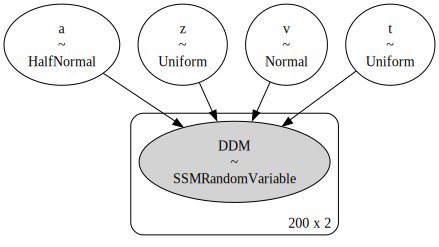

In [72]:
pm.model_to_graphviz(model=ddm_pymc)

Eseguiamo il campionamento.

In [73]:
with ddm_pymc:
    ddm_pymc_trace = pm.sampling_jax.sample_numpyro_nuts(draws=2000, tune=1000)

Compiling...
Compilation time =  0:00:06.676708
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/3000 [00:06<?, ?it/s]




Running chain 0:  10%|█         | 300/3000 [00:07<00:11, 243.68it/s]




Running chain 0:  15%|█▌        | 450/3000 [00:08<00:09, 275.16it/s]


Running chain 0:  20%|██        | 600/3000 [00:08<00:08, 278.29it/s]


Running chain 0:  30%|███       | 900/3000 [00:09<00:06, 325.50it/s]




Running chain 0:  40%|████      | 1200/3000 [00:10<00:05, 318.17it/s]


Running chain 0:  45%|████▌     | 1350/3000 [00:10<00:05, 301.55it/s]


Running chain 0:  50%|█████     | 1500/3000 [00:11<00:05, 293.05it/s]


Running chain 0:  55%|█████▌    | 1650/3000 [00:11<00:04, 309.06it/s]


Running chain 0:  60%|██████    | 1800/3000 [00:12<00:03, 325.27it/s]


Running chain 0:  65%|██████▌   | 1950/3000 [00:12<00:03, 327.77it/s]


Running chain 0:  70%|███████   | 2100/3000 [00:13<00:02, 338.65it/s]


Running chain 0:  75%|███████▌  | 2250/3000 [00:13<00:02, 339.44it/s]


Running chain

Sampling time =  0:00:16.626992
Transforming variables...
Transformation time =  0:00:00.029054


In [56]:
# simple_ddm_model = hssm.HSSM(data=dataset)

In [ ]:
# print(simple_ddm_model)

Otteniamo in questo modo un oggetto `idata` come abbiamo visto in precedenza.

In [74]:
ddm_pymc_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

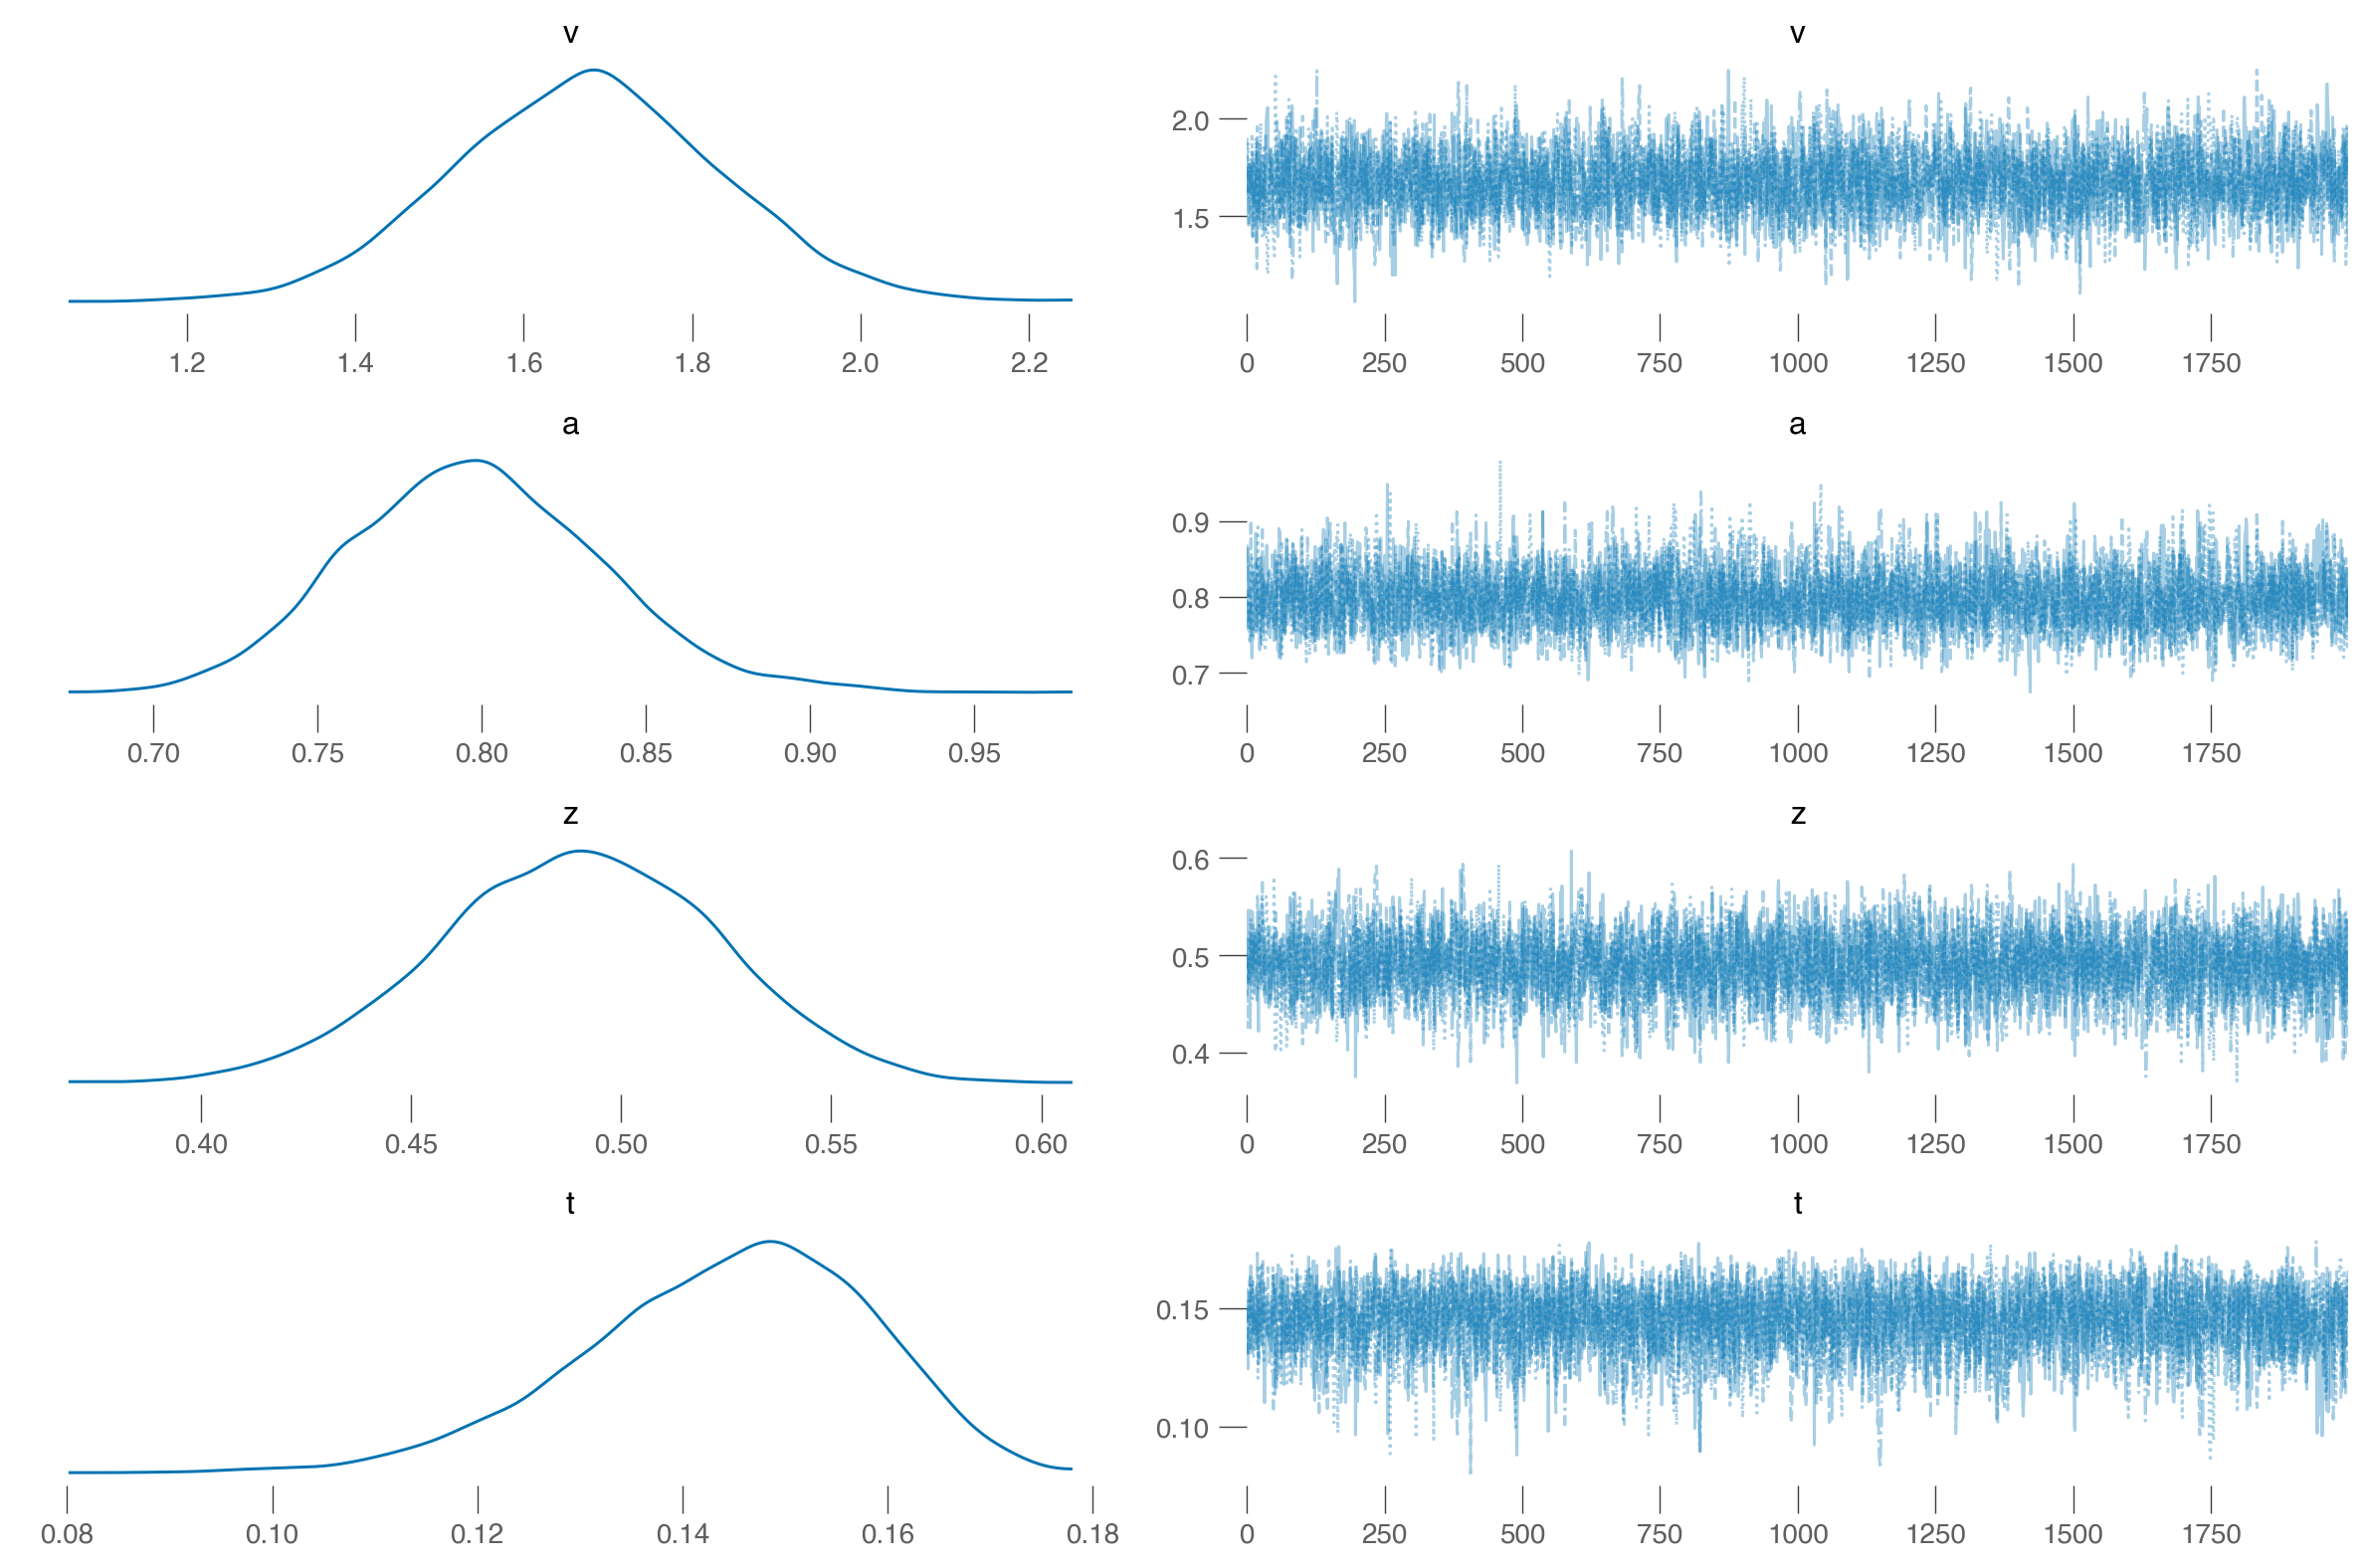

In [76]:
az.plot_trace(ddm_pymc_trace, combined=True)
plt.tight_layout()
plt.show()

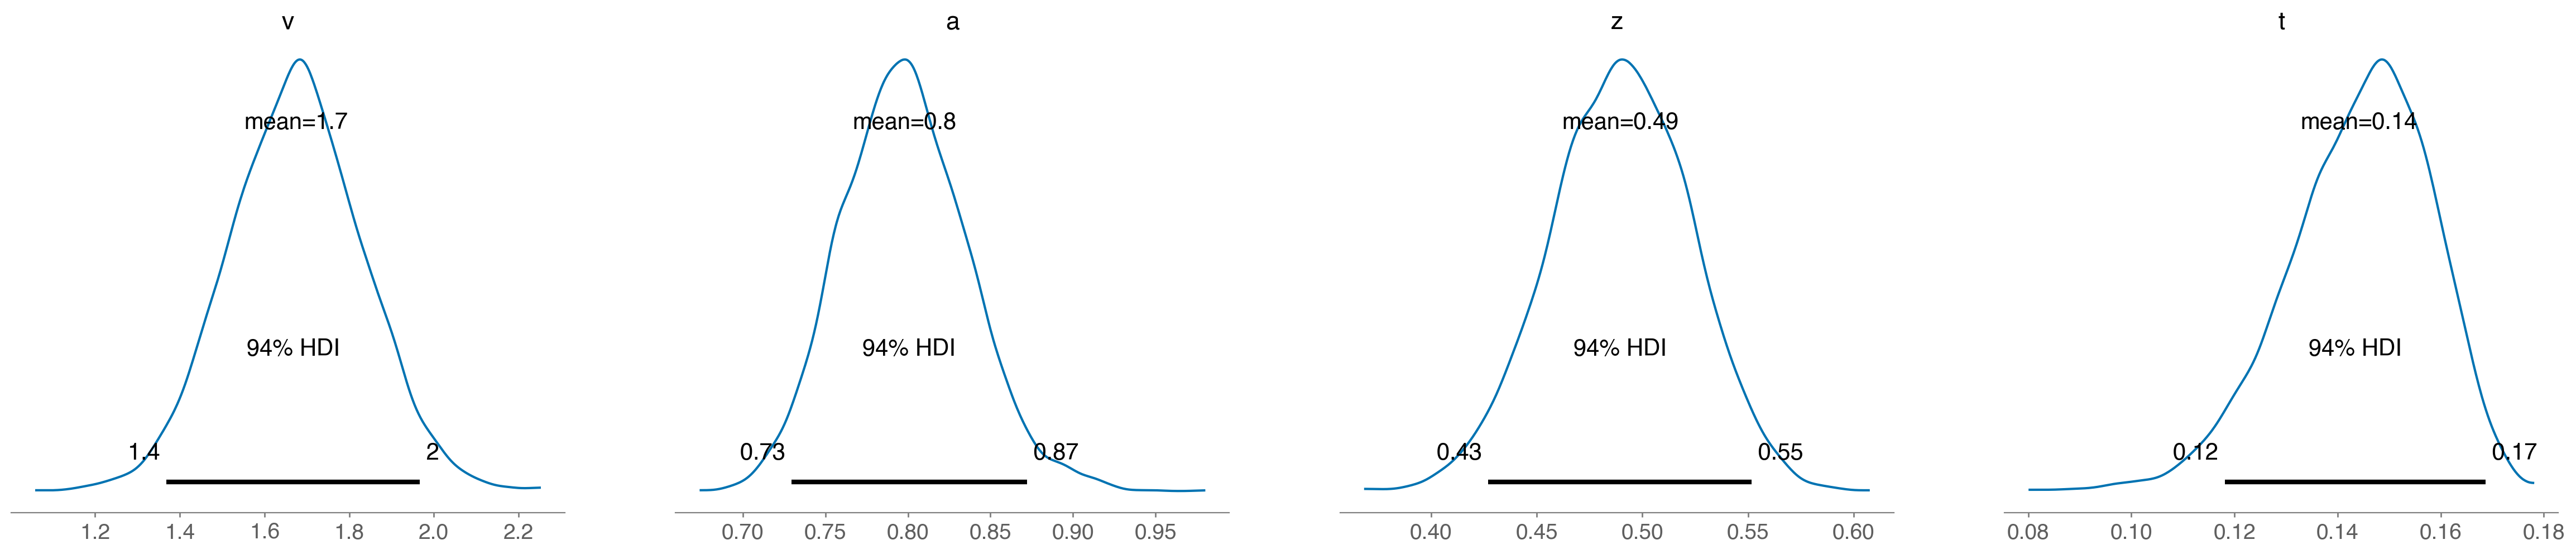

In [78]:
az.plot_posterior(ddm_pymc_trace)
plt.show()

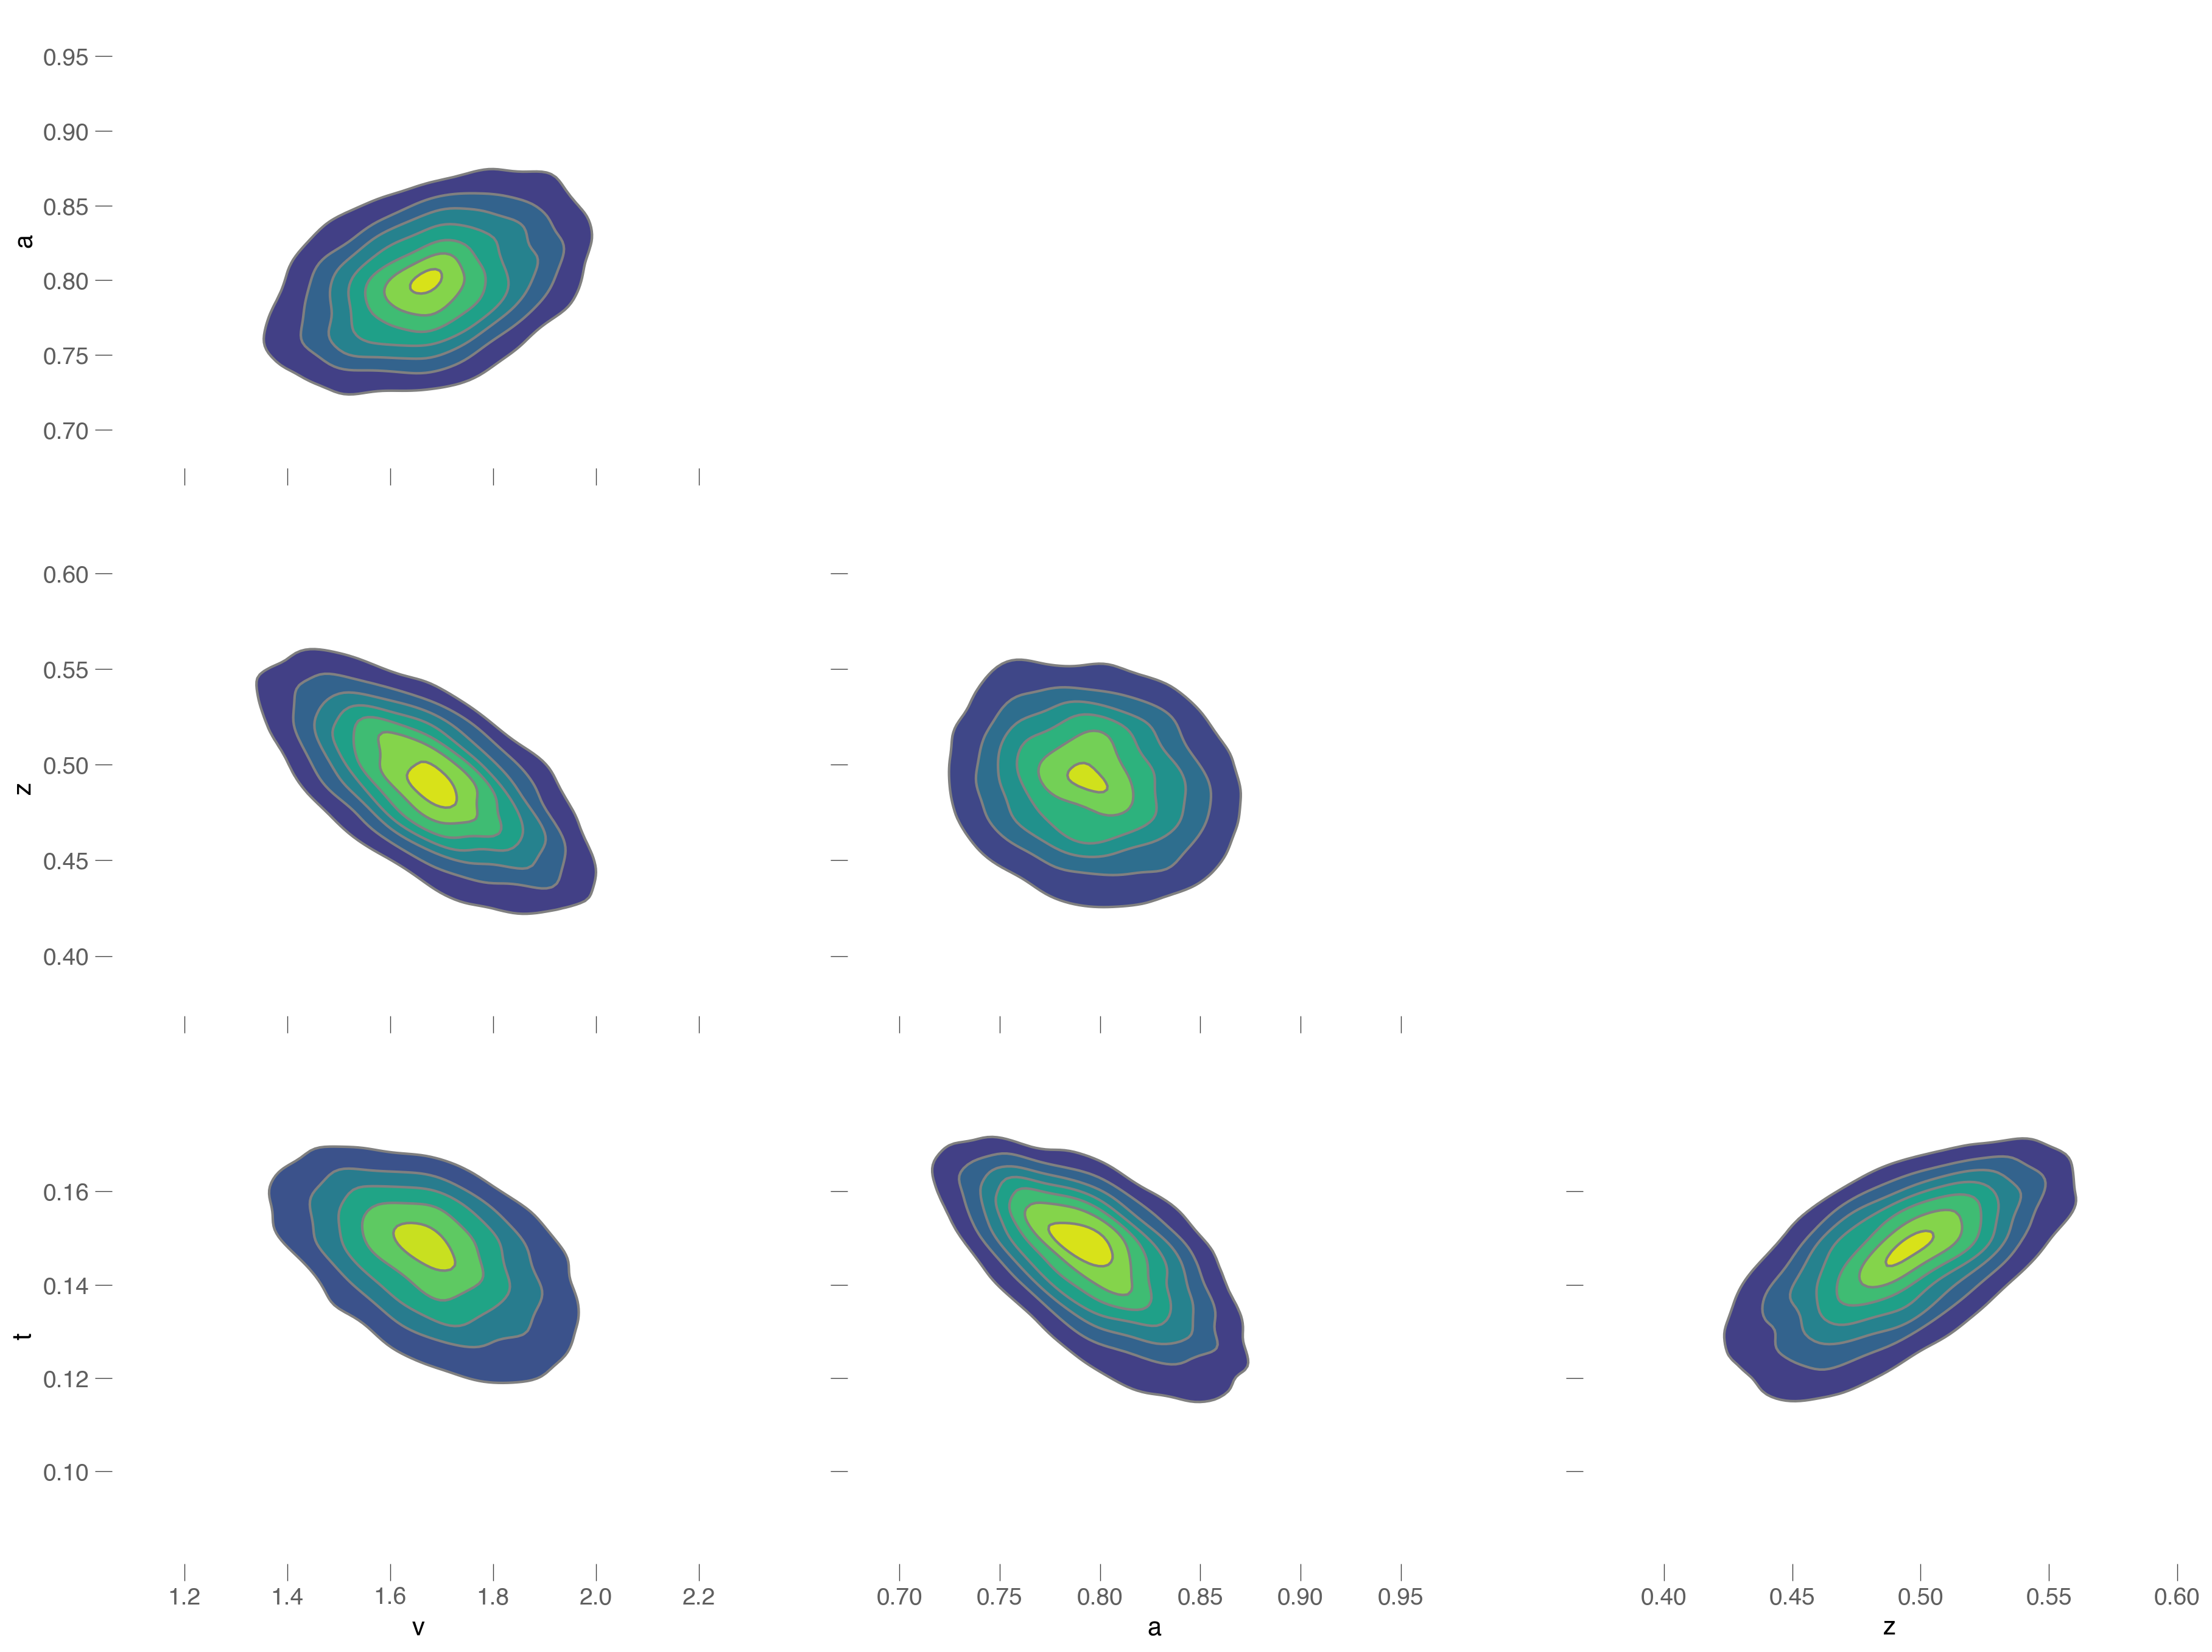

In [79]:
az.plot_pair(ddm_pymc_trace, kind="kde")
plt.show()

In [80]:
az.summary(ddm_pymc_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v,1.675,0.159,1.368,1.967,0.003,0.002,3321.0,4176.0,1.0
a,0.798,0.038,0.729,0.872,0.001,0.000,2967.0,3621.0,1.0
z,0.489,0.033,0.427,0.552,0.001,0.000,3227.0,4335.0,1.0
t,0.144,0.014,0.118,0.169,0.000,0.000,2910.0,3259.0,1.0


Si noti che, con solo 200 osservazioni per soggetto, è stato possibile recuperare con una buona precisione i valore dei parametri del modello DDM usati per simulare i dati.